# Bayesian Optimization from scratch

In [15]:
import sys
sys.path.append('D:/source/repos')
from utilities.std_imports import *
from sklearn.gaussian_process import GaussianProcessRegressor
import numpy.random as rnd
import scipy.stats as ss
from math import pi
from numpy import sin
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
rnd.seed = 9

### Define Objective function

In [16]:
def f_obj(x, noise=0.1):
    fun = x**2 * sin(5 * pi * x)**6.0
    noise = rnd.normal(loc=0, scale=noise)
    return fun + noise

### Generate noisy response

In [17]:
X = np.arange(0, 1, 0.01)
y = [f_obj(x, 0) for x in X]
y_noisy = [f_obj(x, 0.1) for x in X]
pd.DataFrame({'y': y, 'y_noisy':y_noisy}).head(10)

,y,y_noisy
0,0.000000e+00,-0.039559
1,1.465530e-09,-0.171537
2,3.483006e-07,-0.141965
3,7.879943e-06,-0.077936
4,6.598301e-05,-0.209465
5,3.125000e-04,0.212581
6,1.009365e-03,0.162639
7,2.451779e-03,-0.079829
8,4.736068e-03,0.084810
9,7.519770e-03,-0.179232


### Calculate true optima, plot real function and noisy data

Optima: x=0.900, y=0.810


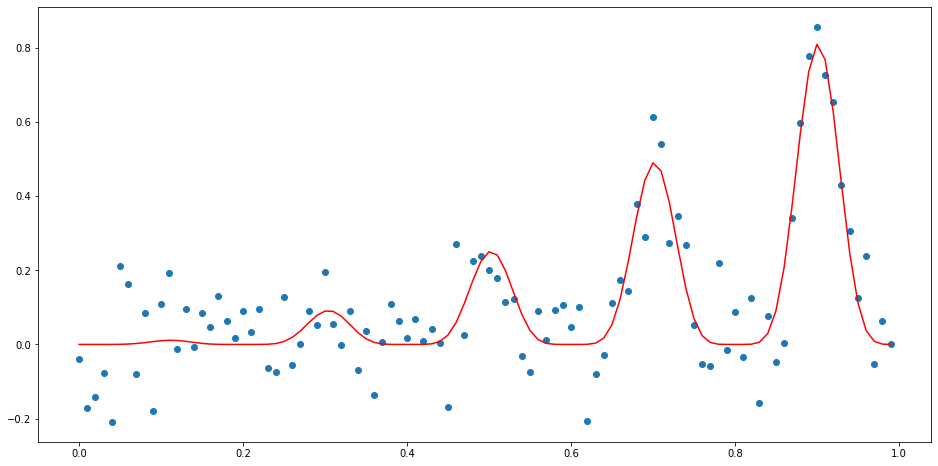

In [18]:
ix = np.argmax(y)
print('Optima: x=%.3f, y=%.3f' % (X[ix], y[ix]))

plt.figure(figsize=[16,8])
plt.scatter(X, y_noisy)
plt.plot(X, y, color='red');

### Bayesian model

##### Generate data and calculate objective function

In [19]:
X = rnd.random(100)
y = np.asarray([f_obj(x) for x in X])
X = X.reshape(len(X), 1)
y = y.reshape(len(y), 1)
X.shape, y.shape

((100, 1), (100, 1))

##### Build model and fit

In [20]:
model = GaussianProcessRegressor()
model = model.fit(X, y)

##### Use the model to define a Surrogate function

In [21]:
def f_surgt(model, X):
    return model.predict(X, return_std=True)

##### Define an Aquisition function : Probability of improvement 

In [22]:
def f_acq(X, Xsamples, model):
    yhat, _ = f_surgt(model, X)
    best = max(yhat)
    mu, std = f_surgt(model, Xsamples)
    mu = mu[:, 0]
    improv_probs = ss.norm.cdf((mu - best) / (std+1E-9))
    return improv_probs

In [23]:
def opt_acquisition(X, y, model):
    Xsamples = rnd.random(100)
    Xsamples = Xsamples.reshape(len(Xsamples), 1)
    scores = f_acq(X, Xsamples, model)
    idx = np.argmax(scores)
    return Xsamples[idx, 0]

### Perform Optimization

In [24]:
def plot_xy(X, y, model, title):
    plt.figure(figsize=[16,8])
    plt.title(title)
    plt.scatter(X, y, color='blue')
    Xsamples = np.asarray(np.arange(0, 1, 0.001))
    Xsamples = Xsamples.reshape(len(Xsamples), 1)
    ysamples, _ = f_surgt(model, Xsamples)
    plt.plot(Xsamples, ysamples, color='red')
    plt.show()

In [25]:
x=np.array([[0.43125]])
x[0][0]
#'{0:.3}'.format(x)

0.43125

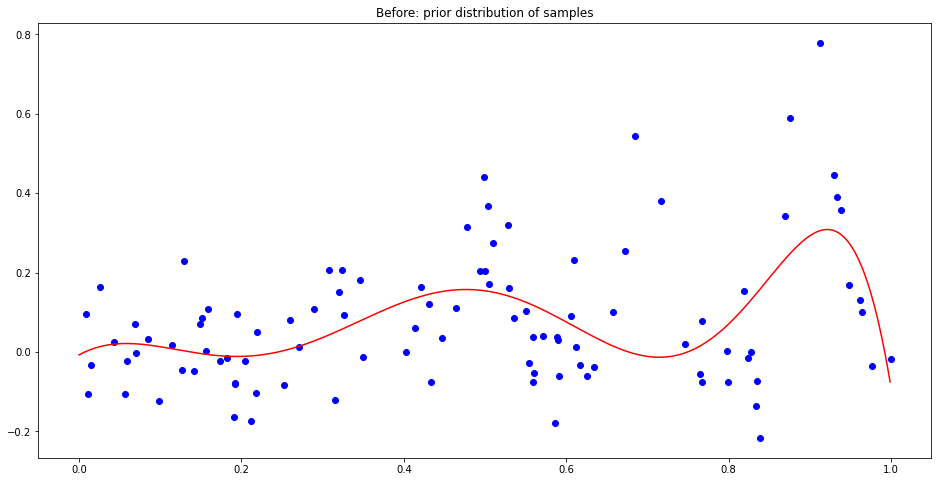

0 : x=  0.919  y_est=  0.308  y_act=  0.619
1 : x=  0.711  y_est=  -0.0206  y_act=  0.254
2 : x=  0.897  y_est=  0.315  y_act=  0.824
3 : x=  0.912  y_est=  0.376  y_act=  0.943
4 : x=  0.918  y_est=  0.426  y_act=  0.725
5 : x=  0.908  y_est=  0.443  y_act=  0.726
6 : x=  0.88  y_est=  0.402  y_act=  0.441
7 : x=  0.926  y_est=  0.468  y_act=  0.369
8 : x=  0.913  y_est=  0.464  y_act=  0.807
9 : x=  0.916  y_est=  0.486  y_act=  0.58
10 : x=  0.919  y_est=  0.491  y_act=  0.633
11 : x=  0.923  y_est=  0.498  y_act=  0.645
12 : x=  0.917  y_est=  0.507  y_act=  0.483
13 : x=  0.916  y_est=  0.505  y_act=  0.673
14 : x=  0.445  y_est=  0.165  y_act=  0.058
15 : x=  0.46  y_est=  0.166  y_act=  0.245
16 : x=  0.499  y_est=  0.169  y_act=  0.278
17 : x=  0.918  y_est=  0.514  y_act=  0.916
18 : x=  0.646  y_est=  0.00157  y_act=  0.0832
19 : x=  0.571  y_est=  0.113  y_act=  0.0848
20 : x=  0.565  y_est=  0.12  y_act=  -0.0971
21 : x=  0.511  y_est=  0.163  y_act=  0.168
22 : x=  0.525  

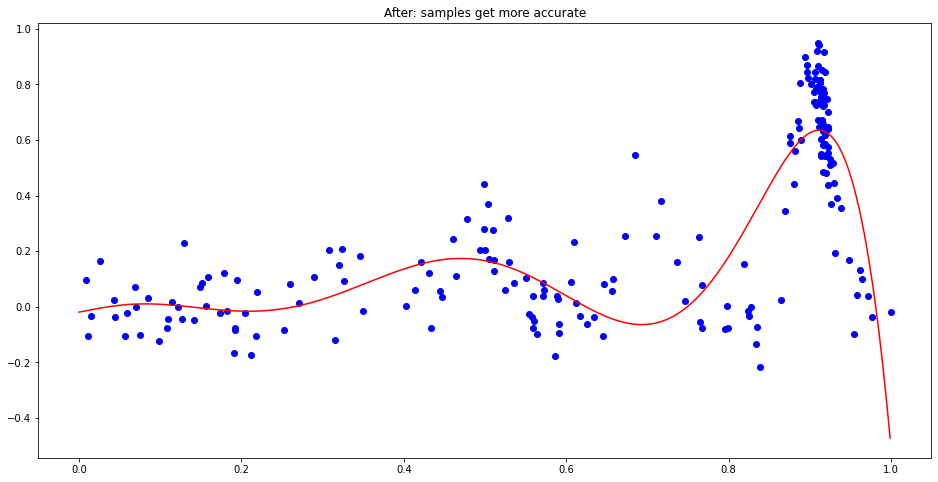

In [26]:
X = rnd.random(100)
y = np.asarray([f_obj(x) for x in X])
X = X.reshape(len(X), 1)
y = y.reshape(len(y), 1)

model = GaussianProcessRegressor()
model = model.fit(X, y)
plot_xy(X, y, model, 'Before: prior distribution of samples')

iterations=100
for i in range(iterations):
    x = opt_acquisition(X, y, model)
    y_act = f_obj(x)
    y_est, _ = f_surgt(model, [[x]])
    print(i, ': x= ', '{0:.3}'.format(x), ' y_est= ', '{0:.3}'.format(y_est[0][0]), ' y_act= ', '{0:.3}'.format(y_act))
    X = np.vstack((X, [[x]]))
    y = np.vstack((y, [[y_act]]))
    model.fit(X, y)

plot_xy(X, y, model, 'After: samples get more accurate')

### Show results

In [27]:
ix = np.argmax(y)
print('Best Result: x=%.3f, y=%.3f' % (X[ix], y[ix]))

Best Result: x=0.910, y=0.950


### Credits & Links

https://machinelearningmastery.com/what-is-bayesian-optimization/